In [1]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
# figure out difference that needs to be made up in rows/columns
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

#after calculating the padding, add in the padding to rows and columns to meet new expected size
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [3]:
def gather_by_name(orignal_path, new_path, phrase):
    n=0
    file_list=[]
    for root, dirs, files in os.walk(os.path.normpath(original_path), topdown=True):
        for name in files:
            if phrase in name:
                file_list.append(os.path.join(root,name))                
                
    for j in range(len(file_list)):
        filename = file_list[j]
        shutil.copy(filename, new_path)

   

    print('copied and moved '+ str(len(file_list))+' files')

In [4]:
def gather_filenames(path):
    raw_path = path
    patient_folders = []
    pt_fnames = []

    import os
    for root, dirs, files in os.walk(os.path.normpath(raw_path), topdown=True):
        for name in files:
            #print(os.path.join(root, name))
            pt_fnames.append(os.path.join(root, name))
    print('\nPatient Folders have been identified\n')
    #sort through and get only the files with ROI in them
    #this eliminates the tiff and 3D files 
    #%%
    ROI_list = []
    for j in range(len(pt_fnames)):
        ROI_name = 'ROI'
        filename = os.path.basename(pt_fnames[j])
        if ROI_name in filename:
            ROI_list.append(pt_fnames[j])
    print('\nFilenames have been found and added\n')
    print('copied and moved '+ str(len(ROI_list))+' files')
    
    return ROI_list

In [5]:
def convert_NPY_NII(ROI_list):
    new_size= new_size
    print('Converting', str(len(ROI_list)), 'files')
    for i in range(len(ROI_list)): # loop through all the available files from the list that had our keyword
        orig_fname = os.path.basename(ROI_list[i])# grab the ith filename in the list
        #print(orig_fname)
        #extract information from the filename
        num_slice = int(orig_fname[-2:])
        #print(num_slice)
        if num_slice < 50:
            #print('over 99')
            num_slice = int(orig_fname[-3:])
            num_width = int((orig_fname[-8:-4]))
            #print(num_width)
            num_height = int((orig_fname[-12:-8]))
            #print(num_height)
        else:
            #print('less than 99')
            num_width = int((orig_fname[-7:-3]))
            #print(num_width)
            num_height = int((orig_fname[-11:-7]))
            #print(num_height)
        pt_numb =(orig_fname[0:6])
        yr_numb = (orig_fname[8])
        if 'Cyst' in orig_fname:
            img_type = 'C'
        elif 'Kidney' in orig_fname:
            img_type = 'M_K'
        elif 'Image' in orig_fname:
            img_type = 'M'
        if 'Right' in orig_fname:
            side = 'R'
        elif 'Left' in orig_fname:
            side = 'L'
        call_file = str(ROI_list[i]) #define our filename with path to open (working_path+'/'+orig_fname)
        resized = np.zeros((num_slice,new_size,new_size), dtype ='uint8')
        transposed = np.zeros((new_size, new_size, num_slice), dtype='uint8')
        with open(r'%s' %call_file, 'rb') as file: #read in raw uint8 and resize correctly
             data = np.fromfile(file, dtype = 'uint8').reshape(num_slice,num_width,num_height)
             for j in range(num_slice):
                 orig_slice = data[j]
                 re_slice = Image.fromarray(orig_slice)
                 resized[j] = resize_with_padding(re_slice, (new_size, new_size))
             for i in range(resized.shape[0]):
                 old_slice = resized[i,:,:]
                 transposed[:,:,i] = old_slice

                 # now we need to rename this resized array and save it as a .npy
        #new_fname = str('%s' %orig_fname + '_RESIZED_') #keep the original name for now 
        new_fname = str(pt_numb +'_'+ yr_numb +'_'+ str(num_slice) +'_'+ side + '_' +  img_type )
        file_name = "%s" %new_fname # add our extension
        np.save(os.path.join(new_path, file_name), transposed) # save in the new file folder
        converted_array = np.array(transposed, dtype=np.float32)
        affine = np.eye(4)
        nifti_file = nib.Nifti1Image(converted_array, affine)
        nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))


    print("complete --- nice job")

In [6]:
from PIL import Image 
from scipy import ndimage

In [7]:
def flip_90_save(List):
    for i in range(len(List)):
        call_file = str(List[i])
        orig_fname = os.path.basename(List[i])
        img_file = nib.load(call_file)
        data_file = img_file.get_fdata()
        rotated_img_90 = ndimage.rotate(data_file, 90, mode='mirror')
        #rotated_img_180 = ndimage.rotate(data_file, 180, mode='mirror')
        new_fname_90 = str('90_'+orig_fname)
        #new_fname_180 = str('180_'+orig_fname)
        affine=np.eye(4)
        nifti_90 = nib.Nifti1Image(rotated_img_90, affine)
        nib.save(nifti_90, os.path.join(final_path, "%s" %new_fname_90))
        #nib.save(rotated_img_180, os.path.join(final_path, "%s" %new_fname_180))
    
    print('complete')

In [8]:
def flip_180_save(List):
    for i in range(len(List)):
        call_file = str(List[i])
        orig_fname = os.path.basename(List[i])
        img_file = nib.load(call_file)
        data_file = img_file.get_fdata()
        
        rotated_img_180 = ndimage.rotate(data_file, 180, mode='mirror')
        
        new_fname_180 = str('180_'+orig_fname)
        affine=np.eye(4)
        nifti_180 = nib.Nifti1Image(rotated_img_180, affine)
        nib.save(nifti_180, os.path.join(final_path, "%s" %new_fname_180))
       
    
    print('complete')

In [10]:
raw_path = r'C:\Users\UAB\data\AllNIIimages'
#new_path = r'C:\Users\UAB\data\AllNPY\\'
final_path = r'C:\Users\UAB\data\RotatedAllNII'
cyst_path = r'C:\Users\UAB\data\CystNII'
new_size = 256

In [13]:
    pt_fnames = []
    for root, dirs, files in os.walk(os.path.normpath(raw_path), topdown=True):
        for name in files:
            #print(os.path.join(root, name))
            pt_fnames.append(os.path.join(root, name))
    print('\nPatient Folders have been identified\n')


Patient Folders have been identified



In [17]:
print(pt_fnames[0])

C:\Users\UAB\data\AllNIIimages\101934_0_96_L_M.nii


In [29]:
flip_90_save(pt_fnames)

complete


In [34]:
flip_180_save(pt_fnames)

complete


## Break out into different sized training batches

In [15]:
data_path = r'C:\Users\UAB\data\RotatedAllNII'
images = []
segmentations = []
for f in os.listdir(data_path):
  if '_K' in f:
    continue
  else:
    images.append(f)
    segmentations.append(f.replace('.nii', '_K.nii'))

print(images[0], segmentations[0])
images = np.array(images)
segmentations = np.array(segmentations)

indices = np.array(range(len(images))) # we will use this in the next step.

101934_0_96_L_M.nii 101934_0_96_L_M_K.nii


In [16]:
print('there are a total of ' + str(len(indices)) + ' images available')

there are a total of 771 images available


In [17]:
def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

In [18]:
def retrieve_images_and_segmentations(data_path, images, segmentations, size=(256,256)):
  x = []
  y = []
  for i in range(len(images)):
    seg = read_nifti_file(data_path+segmentations[i])
    img = read_nifti_file(data_path+images[i])
    assert img.shape == seg.shape
    seg = resize(seg,(size[0], size[1], seg.shape[-1]))
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(seg.shape[-1]):
      # ignore slices that don't have a segmentation
      if np.sum(seg[:,:,j]) == 0:
        continue
      x.append(img[:,:,j])
      y.append(seg[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]
  y = np.array(y)[:,:,:,np.newaxis]

  # randomly shuffle slices
  m = x.shape[0]
  order = np.random.permutation(m)

  return x[order], y[order]

In [19]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')


In [20]:
def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

# Increase to full set of data

In [21]:
train, test = train_test_split(indices, test_size=0.25, random_state=0)

In [25]:
print(len(train))
print(len(images))
data_path = r'C:\Users\UAB\data\RotatedAllNII\\'

433
771


In [26]:
train, valid = train_test_split(train, test_size=0.25, random_state=0) # TODO: split train into training and validation partitions

In [ ]:
x_train, y_train = retrieve_images_and_segmentations(data_path, images[train], segmentations[train]) #TODO: get the matrices for the training partition
print(x_train.shape, y_train.shape)
x_valid, y_valid = retrieve_images_and_segmentations(data_path, images[valid], segmentations[valid]) #TODO: get the matrices for the validation partition
print(x_valid.shape, y_valid.shape)
x_test, y_test = retrieve_images_and_segmentations(data_path, images[test], segmentations[test]) #TODO: get the matrices for the test partition
print(x_test.shape, y_test.shape)

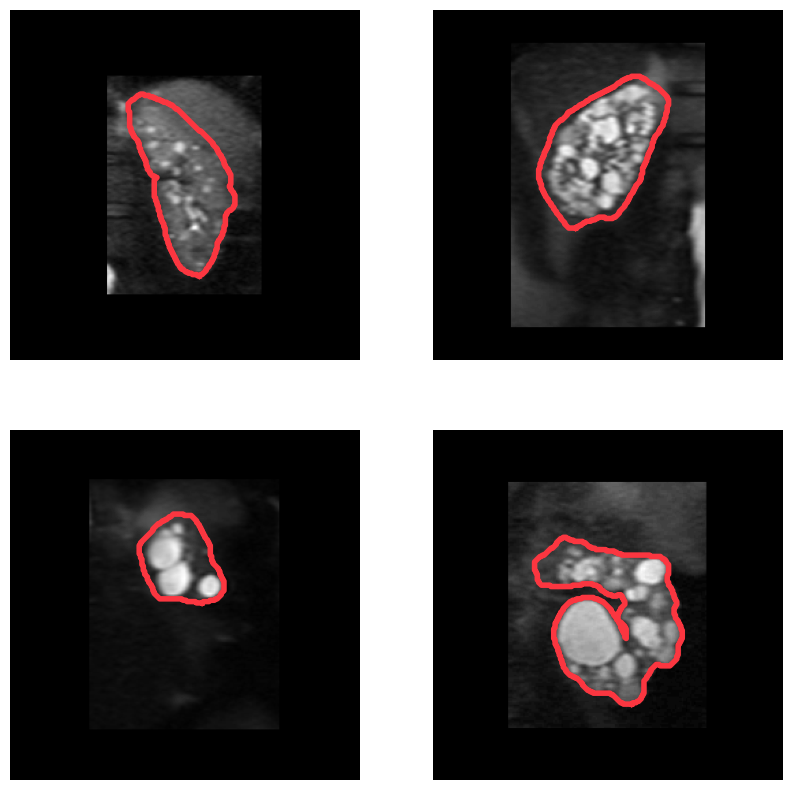

In [18]:
visualise_data(x_train, y_train)
plt.show()

In [19]:
model = custom_unet(input_shape=(256, 256, 1)) #TODO: instantiate the custom_unet object

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #TODO: compile the model as described above
  loss=jaccard_distance,
  metrics=[dice_coef])

history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                    epochs=10)

Epoch 1/10
257/257 [==============================] - 36s 107ms/step - loss: -20.1350 - dice_coef: 1.9409 - val_loss: -20.1430 - val_dice_coef: 1.9671
Epoch 2/10
257/257 [==============================] - 25s 97ms/step - loss: -20.9236 - dice_coef: 1.9711 - val_loss: -20.2110 - val_dice_coef: 1.9737
Epoch 3/10
257/257 [==============================] - 25s 98ms/step - loss: -20.9529 - dice_coef: 1.9735 - val_loss: -20.2400 - val_dice_coef: 1.9765
Epoch 4/10
257/257 [==============================] - 25s 98ms/step - loss: -20.9702 - dice_coef: 1.9750 - val_loss: -20.2461 - val_dice_coef: 1.9769
Epoch 5/10
257/257 [==============================] - 25s 98ms/step - loss: -21.0024 - dice_coef: 1.9777 - val_loss: -20.2728 - val_dice_coef: 1.9795
Epoch 6/10
257/257 [==============================] - 25s 98ms/step - loss: -21.0207 - dice_coef: 1.9794 - val_loss: -20.2802 - val_dice_coef: 1.9803
Epoch 7/10
257/257 [==============================] - 25s 98ms/step - loss: -21.0211 - dice_coef: 1

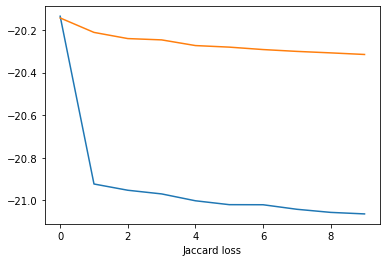

In [20]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

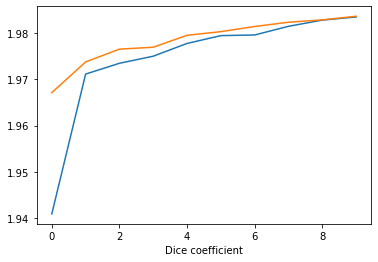

In [21]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [22]:
y_pred_train = model.predict(x_train) #TODO: predict on the training set
y_pred_train = y_pred_train.astype('float')
print('Dice:')
print(np.array(dice_coef(y_train, y_pred_train.astype('float'))))


Dice:
1.9847872857338373


In [23]:
y_pred_valid = model.predict(x_valid) #TODO: predict on the validation set
y_pred_valid = y_pred_valid.astype('float') # casting to type float to avoid ValueError later
print('Dice:')
print(np.array(dice_coef(y_valid, y_pred_valid.astype('float'))))

Dice:
1.9836964587179178


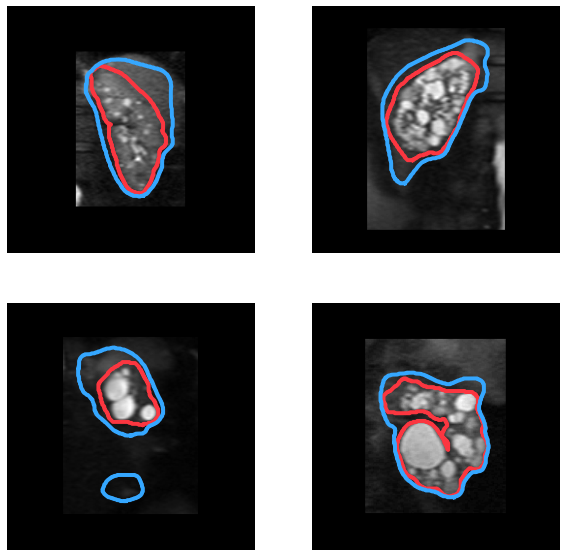

In [26]:
visualise_data_and_prediction(x_train, y_train, y_pred_train)

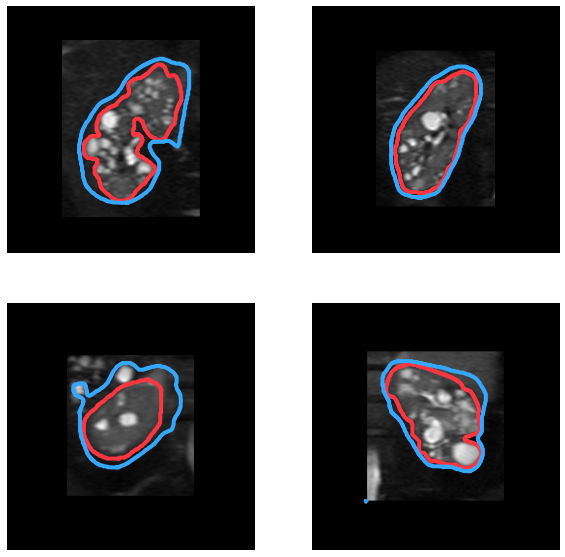

In [27]:
visualise_data_and_prediction(x_valid, y_valid, y_pred_valid)

# Try with more specific unet model

In [9]:
from automouse_model import automouseTKV_model 

In [10]:
img_rows = 256
img_cols = 256

model = automouseTKV_model() #TODO: instantiate the custom_unet object



TypeError: ('Keyword argument not understood:', 'border_mode')

In [44]:

history = model.fit(x_train_80, y_train_80, 
                    validation_data=(x_valid_80, y_valid_80), #TODO: fit the model to the training data, track performance on the validation set and train for 5 epochs.
                       epochs=10)

Epoch 1/10
 41/100 [===========>..................] - ETA: 5s - loss: -22.6962 - dice_coef: 1.9784

KeyboardInterrupt: 

In [ ]:

%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')
​
plt.show()

plt.xlabel('Dice coefficient')
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve
​
plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [ ]:
y_pred_train_20 = model.predict(x_train_20) #TODO: predict on the training set
y_pred_train_20 = y_pred_train_20.astype('float')
print('Dice:')
print(np.array(dice_coef(y_train_20, y_pred_train_20.astype('float'))))

visualise_data_and_prediction(x_valid_20, y_valid_20, y_pred_valid_20)